In [6]:
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# 设备设置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 数据增强和预处理
train_transform_aug = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_transform_no_aug = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 加载数据集
train_data_aug = datasets.ImageFolder('a5_data/train', transform=train_transform_aug)
train_data_no_aug = datasets.ImageFolder('a5_data/train', transform=train_transform_no_aug)
val_data = datasets.ImageFolder('a5_data/val', transform=val_transform)

train_loader_aug = DataLoader(train_data_aug, batch_size=32, shuffle=True)
train_loader_no_aug = DataLoader(train_data_no_aug, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)


In [7]:
#定义模型
class SimpleCNN(nn.Module):
    def __init__(self, use_bn=False, use_residual=False):
        super(SimpleCNN, self).__init__()
        self.use_residual = use_residual
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64) if use_bn else nn.Identity()
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128) if use_bn else nn.Identity()
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256) if use_bn else nn.Identity()
        self.fc = None

        # 残差连接的1x1卷积
        if use_residual:
            self.residual_conv = nn.Conv2d(3, 256, kernel_size=1, stride=4)  # 调整通道数和空间维度

    def forward(self, x):
        residual = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)  # 224x224 -> 112x112
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)  # 112x112 -> 56x56
        x = self.conv3(x)
        x = self.bn3(x)

        # 调整残差连接的形状
        if self.use_residual:
            residual = self.residual_conv(residual)  # 调整通道数和空间维度
            x += residual

        x = self.relu(x)
        x = x.view(x.size(0), -1)  # 展平

        # 动态计算全连接层的输入维度
        if self.fc is None:
            self.fc = nn.Linear(x.size(1), 2).to(x.device)
        x = self.fc(x)
        return x

In [8]:
# 训练函数
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses, val_losses, val_accuracies = [], [], []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        # 验证集评估
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss /= len(val_loader)
        val_accuracy = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    
    return train_losses, val_losses, val_accuracies



In [9]:
# 对比实验
num_epochs = 20
results = {}

# 基线模型（无归一化、无残差连接、无数据增强）
model = SimpleCNN(use_bn=False, use_residual=False).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)  # 调整学习率
criterion = nn.CrossEntropyLoss()
train_losses, val_losses, val_accuracies = train_model(model, train_loader_no_aug, val_loader, criterion, optimizer, num_epochs)
results['Baseline'] = {'train_loss': train_losses, 'val_loss': val_losses, 'val_accuracy': val_accuracies}

Epoch 1/20, Train Loss: 0.4467, Val Loss: 0.4211, Val Accuracy: 0.7907
Epoch 2/20, Train Loss: 0.3954, Val Loss: 0.4065, Val Accuracy: 0.7899
Epoch 3/20, Train Loss: 0.3769, Val Loss: 0.3997, Val Accuracy: 0.7995
Epoch 4/20, Train Loss: 0.3661, Val Loss: 0.3952, Val Accuracy: 0.7923
Epoch 5/20, Train Loss: 0.3452, Val Loss: 0.4014, Val Accuracy: 0.8091
Epoch 6/20, Train Loss: 0.3303, Val Loss: 0.3756, Val Accuracy: 0.8059
Epoch 7/20, Train Loss: 0.3220, Val Loss: 0.3652, Val Accuracy: 0.8163
Epoch 8/20, Train Loss: 0.2967, Val Loss: 0.3737, Val Accuracy: 0.8315
Epoch 9/20, Train Loss: 0.2830, Val Loss: 0.3844, Val Accuracy: 0.8075
Epoch 10/20, Train Loss: 0.2630, Val Loss: 0.3775, Val Accuracy: 0.8267
Epoch 11/20, Train Loss: 0.2486, Val Loss: 0.3740, Val Accuracy: 0.8299
Epoch 12/20, Train Loss: 0.2258, Val Loss: 0.4068, Val Accuracy: 0.8235
Epoch 13/20, Train Loss: 0.2098, Val Loss: 0.4182, Val Accuracy: 0.8155
Epoch 14/20, Train Loss: 0.1872, Val Loss: 0.4224, Val Accuracy: 0.8155
E

In [10]:
# 添加批量归一化
model = SimpleCNN(use_bn=True, use_residual=False).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)  # 调整学习率
train_losses, val_losses, val_accuracies = train_model(model, train_loader_no_aug, val_loader, criterion, optimizer, num_epochs)
results['With BN'] = {'train_loss': train_losses, 'val_loss': val_losses, 'val_accuracy': val_accuracies}

Epoch 1/20, Train Loss: 0.4090, Val Loss: 0.3896, Val Accuracy: 0.8123
Epoch 2/20, Train Loss: 0.3704, Val Loss: 0.3769, Val Accuracy: 0.8195
Epoch 3/20, Train Loss: 0.3414, Val Loss: 0.3577, Val Accuracy: 0.8251
Epoch 4/20, Train Loss: 0.3252, Val Loss: 0.3591, Val Accuracy: 0.8219
Epoch 5/20, Train Loss: 0.3087, Val Loss: 0.3557, Val Accuracy: 0.8355
Epoch 6/20, Train Loss: 0.2891, Val Loss: 0.3641, Val Accuracy: 0.8259
Epoch 7/20, Train Loss: 0.2742, Val Loss: 0.3577, Val Accuracy: 0.8347
Epoch 8/20, Train Loss: 0.2578, Val Loss: 0.3455, Val Accuracy: 0.8435
Epoch 9/20, Train Loss: 0.2408, Val Loss: 0.3349, Val Accuracy: 0.8315
Epoch 10/20, Train Loss: 0.2180, Val Loss: 0.3472, Val Accuracy: 0.8371
Epoch 11/20, Train Loss: 0.2040, Val Loss: 0.3352, Val Accuracy: 0.8482
Epoch 12/20, Train Loss: 0.1831, Val Loss: 0.3340, Val Accuracy: 0.8419
Epoch 13/20, Train Loss: 0.1629, Val Loss: 0.3502, Val Accuracy: 0.8211
Epoch 14/20, Train Loss: 0.1494, Val Loss: 0.3286, Val Accuracy: 0.8458
E

In [11]:
# 添加残差连接
model = SimpleCNN(use_bn=False, use_residual=True).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)  # 调整学习率
train_losses, val_losses, val_accuracies = train_model(model, train_loader_no_aug, val_loader, criterion, optimizer, num_epochs)
results['With Residual'] = {'train_loss': train_losses, 'val_loss': val_losses, 'val_accuracy': val_accuracies}

Epoch 1/20, Train Loss: 0.4416, Val Loss: 0.4245, Val Accuracy: 0.7891
Epoch 2/20, Train Loss: 0.3974, Val Loss: 0.4033, Val Accuracy: 0.7899
Epoch 3/20, Train Loss: 0.3795, Val Loss: 0.3999, Val Accuracy: 0.7843
Epoch 4/20, Train Loss: 0.3604, Val Loss: 0.3796, Val Accuracy: 0.8099
Epoch 5/20, Train Loss: 0.3416, Val Loss: 0.3726, Val Accuracy: 0.8171
Epoch 6/20, Train Loss: 0.3210, Val Loss: 0.3723, Val Accuracy: 0.8187
Epoch 7/20, Train Loss: 0.3101, Val Loss: 0.3685, Val Accuracy: 0.8219
Epoch 8/20, Train Loss: 0.2895, Val Loss: 0.3718, Val Accuracy: 0.8179
Epoch 9/20, Train Loss: 0.2712, Val Loss: 0.3772, Val Accuracy: 0.8267
Epoch 10/20, Train Loss: 0.2461, Val Loss: 0.4088, Val Accuracy: 0.8219
Epoch 11/20, Train Loss: 0.2286, Val Loss: 0.4000, Val Accuracy: 0.8203
Epoch 12/20, Train Loss: 0.2071, Val Loss: 0.4048, Val Accuracy: 0.8219
Epoch 13/20, Train Loss: 0.1848, Val Loss: 0.4314, Val Accuracy: 0.8123
Epoch 14/20, Train Loss: 0.1650, Val Loss: 0.4407, Val Accuracy: 0.8219
E

In [12]:

# 添加数据增强
model = SimpleCNN(use_bn=False, use_residual=False).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)  # 调整学习率
train_losses, val_losses, val_accuracies = train_model(model, train_loader_aug, val_loader, criterion, optimizer, num_epochs)
results['With Data Augmentation'] = {'train_loss': train_losses, 'val_loss': val_losses, 'val_accuracy': val_accuracies}

Epoch 1/20, Train Loss: 0.5669, Val Loss: 0.4706, Val Accuracy: 0.7460
Epoch 2/20, Train Loss: 0.5339, Val Loss: 0.4552, Val Accuracy: 0.7588
Epoch 3/20, Train Loss: 0.5279, Val Loss: 0.4524, Val Accuracy: 0.7604
Epoch 4/20, Train Loss: 0.5294, Val Loss: 0.4458, Val Accuracy: 0.7676
Epoch 5/20, Train Loss: 0.5243, Val Loss: 0.4332, Val Accuracy: 0.7628
Epoch 6/20, Train Loss: 0.5125, Val Loss: 0.4251, Val Accuracy: 0.7796
Epoch 7/20, Train Loss: 0.5085, Val Loss: 0.4430, Val Accuracy: 0.7684
Epoch 8/20, Train Loss: 0.5161, Val Loss: 0.4351, Val Accuracy: 0.7772
Epoch 9/20, Train Loss: 0.5126, Val Loss: 0.4259, Val Accuracy: 0.7772
Epoch 10/20, Train Loss: 0.5055, Val Loss: 0.4185, Val Accuracy: 0.7867
Epoch 11/20, Train Loss: 0.5107, Val Loss: 0.4232, Val Accuracy: 0.7859
Epoch 12/20, Train Loss: 0.5016, Val Loss: 0.4240, Val Accuracy: 0.7843
Epoch 13/20, Train Loss: 0.5004, Val Loss: 0.4159, Val Accuracy: 0.7851
Epoch 14/20, Train Loss: 0.4967, Val Loss: 0.4051, Val Accuracy: 0.7915
E

In [13]:

# 添加迁移学习（使用预训练的 ResNet18）
model = torchvision.models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)
optimizer = optim.Adam(model.fc.parameters(), lr=0.0005)  # 调整学习率
train_losses, val_losses, val_accuracies = train_model(model, train_loader_no_aug, val_loader, criterion, optimizer, num_epochs)
results['With Transfer Learning'] = {'train_loss': train_losses, 'val_loss': val_losses, 'val_accuracy': val_accuracies}

c:\Users\11492\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\11492\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\11492/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


Epoch 1/20, Train Loss: 0.4726, Val Loss: 0.3610, Val Accuracy: 0.8283
Epoch 2/20, Train Loss: 0.3696, Val Loss: 0.3425, Val Accuracy: 0.8490
Epoch 3/20, Train Loss: 0.3556, Val Loss: 0.3247, Val Accuracy: 0.8435
Epoch 4/20, Train Loss: 0.3523, Val Loss: 0.3182, Val Accuracy: 0.8538
Epoch 5/20, Train Loss: 0.3393, Val Loss: 0.3147, Val Accuracy: 0.8578
Epoch 6/20, Train Loss: 0.3309, Val Loss: 0.3156, Val Accuracy: 0.8570
Epoch 7/20, Train Loss: 0.3323, Val Loss: 0.3098, Val Accuracy: 0.8578
Epoch 8/20, Train Loss: 0.3264, Val Loss: 0.3117, Val Accuracy: 0.8546
Epoch 9/20, Train Loss: 0.3165, Val Loss: 0.3081, Val Accuracy: 0.8578
Epoch 10/20, Train Loss: 0.3222, Val Loss: 0.3153, Val Accuracy: 0.8586
Epoch 11/20, Train Loss: 0.3240, Val Loss: 0.3171, Val Accuracy: 0.8554
Epoch 12/20, Train Loss: 0.3208, Val Loss: 0.3190, Val Accuracy: 0.8538
Epoch 13/20, Train Loss: 0.3193, Val Loss: 0.3226, Val Accuracy: 0.8522
Epoch 14/20, Train Loss: 0.3143, Val Loss: 0.3169, Val Accuracy: 0.8618
E

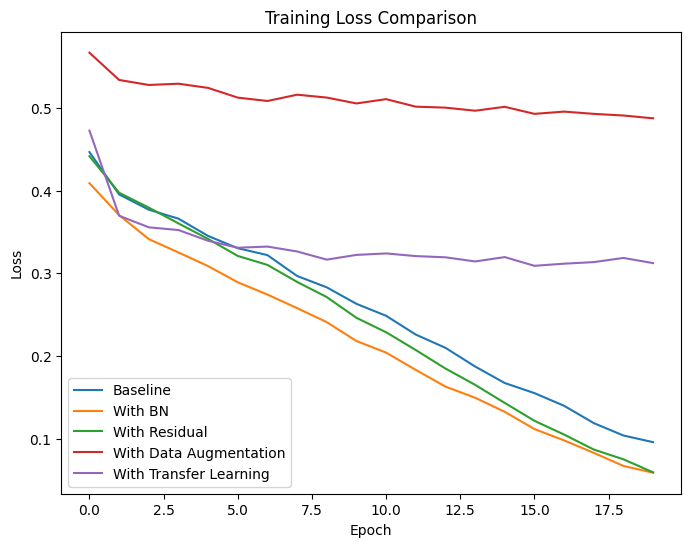

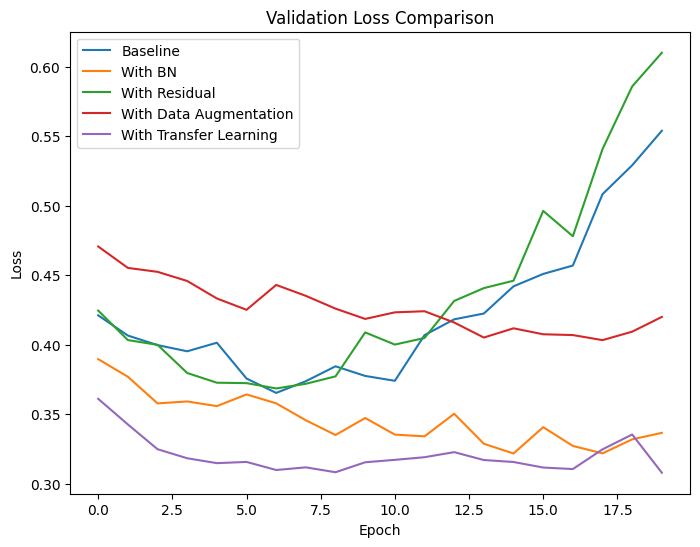

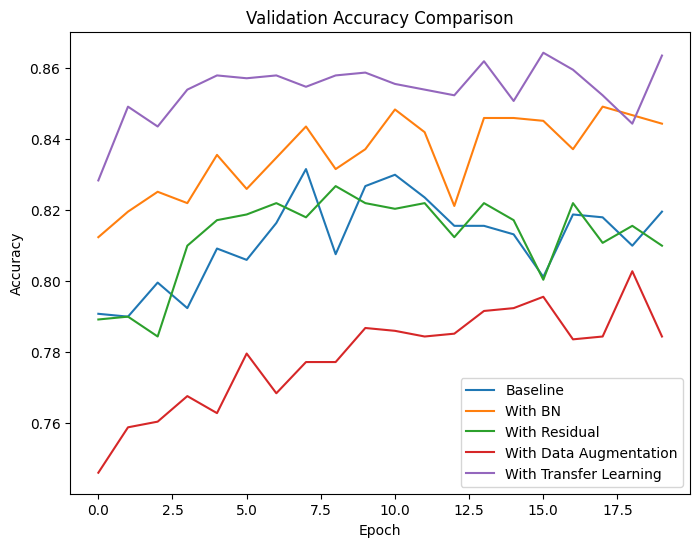

In [14]:

# 绘制训练损失对比
plt.figure(figsize=(8, 6))
for label, data in results.items():
    plt.plot(data['train_loss'], label=label)
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 绘制验证损失对比
plt.figure(figsize=(8, 6))
for label, data in results.items():
    plt.plot(data['val_loss'], label=label)
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 绘制验证准确率对比
plt.figure(figsize=(8, 6))
for label, data in results.items():
    plt.plot(data['val_accuracy'], label=label)
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()